### Tree-based Modelling EDA
Using the existing DataLoader and DataCleaner functionality, I aim to explore different tree-based models. I am expecting to settle for a XGBoost model.

I will also use this notebook to explore feature selection techniques 

In [192]:
# Data Preprocessing
from data_preprocessing.DataLoader import DataLoader
from data_preprocessing.DataCleaner import DataCleaner
from sklearn.model_selection import train_test_split

# Modelling
import xgboost as xgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesClassifier

# Feature Selection
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score, GridSearchCV

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Hyper param Tuning
from hpsklearn import HyperoptEstimator, random_forest_regressor, xgboost_regression
from hyperopt import hp

# General
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [193]:
# X_train = pd.read_csv('X_train.csv')
# X_test = pd.read_csv('X_test.csv')
# y_train = pd.read_csv('y_train.csv')
# y_test = pd.read_csv('y_test.csv')

In [194]:
data_loader = DataLoader(path="car_data.parquet.gzip")
df = data_loader.load_parquet()
data_cleaner = DataCleaner(df)

data_cleaner.clean_data()
new_df = data_cleaner.get_df()
new_outlier_df = data_cleaner.get_outlier_df()

# Split data and drop old columns
X_train, X_test, y_train, y_test = data_loader.split_data(new_df)
data_cleaner.drop_columns(X_train)
data_cleaner.drop_columns(X_test)
# Encode to ordinal based on train set
columns_to_ordinal = ["co2_grouped", "engine_size_grouped", "owners_grouped", "fuel_type_grouped", "make_grouped", "doors_grouped", "seats_grouped"]
data_cleaner.convert_columns_to_ordinal(columns_to_ordinal, X_train, y_train, X_test)

# Outlier data and drop
X_train_outlier, X_test_outlier, y_train_outlier, y_test_outlier = data_loader.split_data(new_outlier_df, test_size=0.1)
data_cleaner.drop_columns(X_train_outlier)
data_cleaner.drop_columns(X_test_outlier)
# Encode to ordinal based on train set
columns_to_ordinal = ["co2_grouped", "engine_size_grouped", "owners_grouped", "fuel_type_grouped", "make_grouped", "doors_grouped", "seats_grouped"]
data_cleaner.convert_columns_to_ordinal(columns_to_ordinal, X_train_outlier, y_train_outlier, X_test_outlier)

Number of outliers: 2212
Percentage of tota ingest dataset: 0.98%
Number of extreme outliers removed: 171
Percentage of tota ingest dataset: 0.08%


## Feature Selection using an ExtraTreesClassifier
<u> What is an ExtraTrees Model and How does it differ to a Random Forest? </u>  
Extra trees are also know as <a href="https://orbi.uliege.be/bitstream/2268/9357/1/geurts-mlj-advance.pdf"><b>Extremely Random Trees</b></a>

- Random forest uses boostrap replicas (subsamples input with replacement)
- Extra Trees use whole original sample (bootstrapping is optional arg in scikit)
- Random forest chooses the optimum split for each branch
- Extra Trees choose these splits randomly
- Extra trees are computationally more efficient than other ensemble methods

In [195]:
columns_to_keep = ["is_private_plate",
"mileage_deviation_encoded",
"image_count",
"advert_sentiment",
"advert_title_sentiment",
"make_grouped",
"fuel_type_grouped",
"doors_grouped",
"seats_grouped",
"owners_grouped",
"engine_size_grouped",
"co2_grouped"]

outlier_cols_to_keep = [
    'is_ulez', 
    'is_convetible', 
    'is_private_plate', 
    'mileage_deviation_encoded', 
    'image_count', 
    'advert_sentiment', 
    'advert_title_sentiment', 
    'make_grouped', 
    'doors_grouped', 
    'seats_grouped', 
    'owners_grouped', 
    'co2_grouped'
    ]

# X_train = np.array(X_train[columns_to_keep])
# X_test = np.array(X_test[columns_to_keep])
# X_train_outlier = np.array(X_train_outlier[columns_to_keep])
# X_test_outlier = np.array(X_test_outlier[columns_to_keep])

y_train = np.reshape(np.array(y_train), (-1, ))
y_test = np.reshape(np.array(y_test), (-1, ))
y_train_outlier = np.reshape(np.array(y_train_outlier), (-1, ))
y_test_outlier = np.reshape(np.array(y_test_outlier), (-1, ))

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=1337, test_size=0.1)
X_train_outlier, X_val_outlier, y_train_outlier, y_val_outlier = train_test_split(X_train_outlier, y_train_outlier, random_state=1337, test_size=0.1)

extra_tree_clf = ExtraTreesClassifier(n_estimators=20, max_depth=16, min_samples_split=4, random_state=1337, bootstrap=True, n_jobs=-1)

In [196]:
extra_tree_clf.fit(X_train, y_train)
importance_dict = dict(zip(X_train.columns, extra_tree_clf.feature_importances_))
importance_dict = dict(sorted(importance_dict.items(), key=lambda item: item[1], reverse=True))
for k,v in importance_dict.items():
    print(f"{k} : {v}")

image_count : 0.17982860122557603
co2_grouped : 0.10170378648937936
make_grouped : 0.08095644674004024
owners_grouped : 0.07606071155582068
advert_title_sentiment : 0.06810064908283472
advert_sentiment : 0.06690251304570635
mileage_deviation_encoded : 0.05270487609133935
seats_grouped : 0.049681812456335975
doors_grouped : 0.04070119327602492
fuel_type_grouped : 0.03785568727977977
engine_size_grouped : 0.03332637116259071
is_private_plate : 0.02963913314321583
is_manual : 0.020935311284902502
is_ulez : 0.018135864738348252
is_convertible : 0.012734240297676742
model_col_0 : 0.009357292634119985
is_new : 0.008667314690088978
model_col_10 : 0.008412134756960349
model_col_2 : 0.007863729206496677
model_col_8 : 0.0076790463576273974
model_col_1 : 0.007563119878066668
model_col_15 : 0.007534993740697417
model_col_6 : 0.007412288142728348
model_col_11 : 0.00726612750997319
model_col_3 : 0.007232882551105653
model_col_4 : 0.007165748430608404
model_col_14 : 0.006971249656678823
model_col_13 

In [197]:
# importance_dict
print(f"Old shape: {X_train.shape}")
model = SelectFromModel(extra_tree_clf, prefit=True)
X_new = model.transform(X_train)
features_out = model.get_feature_names_out(input_features=X_train.columns)
print(f"New shape: {X_new.shape}")

Old shape: (140553, 39)
New shape: (140553, 12)


/opt/anaconda3/envs/pyZak/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


#### Outlier Feature Selection

In [198]:
extra_tree_clf = ExtraTreesClassifier(n_estimators=50, max_depth=16, min_samples_split=4, random_state=1337, bootstrap=True, n_jobs=-1)
extra_tree_clf.fit(X_train_outlier, y_train_outlier)
outlier_importance_dict = dict(zip(X_train_outlier.columns, extra_tree_clf.feature_importances_))
outlier_importance_dict = dict(sorted(outlier_importance_dict.items(), key=lambda item: item[1], reverse=True))
for k,v in outlier_importance_dict.items():
    print(f"{k} : {v}")

# outlier importance_dict
print(f"Old shape: {X_train_outlier.shape}")
outlier_model = SelectFromModel(extra_tree_clf, prefit=True)
X_new_outlier = outlier_model.transform(X_train_outlier)
outlier_features_out = outlier_model.get_feature_names_out(input_features=X_train_outlier.columns)
print(f"New shape: {X_new_outlier.shape}")

image_count : 0.187433442611285
owners_grouped : 0.09583713461014913
mileage_deviation_encoded : 0.07288524962366635
advert_sentiment : 0.05963210913161863
seats_grouped : 0.055105744539096044
advert_title_sentiment : 0.054502885239962204
is_private_plate : 0.050585260347713774
make_grouped : 0.0411533106551515
is_convertible : 0.04018154770398957
doors_grouped : 0.03671412334248131
co2_grouped : 0.03164435631056269
is_ulez : 0.02995142119122626
engine_size_grouped : 0.020488684972466364
is_manual : 0.01694211705218163
is_new : 0.01689120162099682
fuel_type_grouped : 0.015926157379464265
model_col_10 : 0.015483729116113
model_col_1 : 0.014140653096739047
model_col_11 : 0.014109504494970367
model_col_15 : 0.014052987947560562
model_col_2 : 0.013672628378984484
model_col_0 : 0.011884136889721892
model_col_9 : 0.010997482438120298
is_imported : 0.010204387004190798
model_col_8 : 0.009197258923320234
model_col_7 : 0.008964629068141277
model_col_5 : 0.008856759509299482
model_col_13 : 0.008

/opt/anaconda3/envs/pyZak/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [199]:
for f1, f2 in zip(features_out, outlier_features_out):
    print(f"{f1} : {importance_dict[f1]:.4f}\t{f2} : {outlier_importance_dict[f2]:.4f}")
outlier_cols_to_keep = [
    'is_ulez', 
    'is_convetible', 
    'is_private_plate', 
    'mileage_deviation_encoded', 
    'image_count', 
    'advert_sentiment', 
    'advert_title_sentiment', 
    'make_grouped', 
    'doors_grouped', 
    'seats_grouped', 
    'owners_grouped', 
    'co2_grouped'
    ]

is_private_plate : 0.0296	is_ulez : 0.0300
mileage_deviation_encoded : 0.0527	is_convertible : 0.0402
image_count : 0.1798	is_private_plate : 0.0506
advert_sentiment : 0.0669	mileage_deviation_encoded : 0.0729
advert_title_sentiment : 0.0681	image_count : 0.1874
make_grouped : 0.0810	advert_sentiment : 0.0596
fuel_type_grouped : 0.0379	advert_title_sentiment : 0.0545
doors_grouped : 0.0407	make_grouped : 0.0412
seats_grouped : 0.0497	doors_grouped : 0.0367
owners_grouped : 0.0761	seats_grouped : 0.0551
engine_size_grouped : 0.0333	owners_grouped : 0.0958
co2_grouped : 0.1017	co2_grouped : 0.0316


### Metric Choice
1. MAE
 - Easy to interpret and gives less weight to outliers
2. MSE
- Will  be sensitive to hypercar outliers and needs reformatting for interpretation
3. RMSE
- Also sensitive to hypercar outliers but already rooted so easier to interpret

## Base Model - Decision Tree

In [200]:
X_train = X_new
model_mask = model.get_support()
outlier_model_mask = outlier_model.get_support()

model_feature_map = dict(zip([_ for _ in range(len(model_mask))], features_out))
outlier_model_feature_map = dict(zip([_ for _ in range(len(outlier_model_mask))], [outlier_features_out]))

X_test = np.array(X_test.loc[:, model_mask])
X_val = np.array(X_val.loc[:, model_mask])

X_train_outlier = X_new_outlier
X_test_outlier = np.array(X_test_outlier.loc[:, outlier_model_mask])
X_val_outlier = np.array(X_val_outlier.loc[:, outlier_model_mask])

def output_score(scores):
    print(f"Mean: {abs(scores.mean()):.3f} (std: {scores.std():.3f})\n\n")

In [202]:
dt = DecisionTreeRegressor(max_depth=32, random_state=1337)
basic_dt_scores = cross_val_score(dt, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')

## Random Forest

In [203]:
rf = RandomForestRegressor(n_estimators=100, max_depth=16, random_state=1337, n_jobs=-1)
basic_rf_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')

### Gradient Boosting Regressor

In [204]:
gb = GradientBoostingRegressor(n_estimators=100, max_depth=16, random_state=1337, learning_rate=0.3, n_iter_no_change=5)
basic_gb_scores = cross_val_score(gb, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')

In [205]:
print("DT")
output_score(basic_dt_scores)
print("RF")
output_score(basic_rf_scores)
print("GB")
output_score(basic_gb_scores)

DT
Mean: 5580.904 (std: 32.443)


RF
Mean: 4645.505 (std: 36.199)


GB
Mean: 4751.058 (std: 25.442)




## Best Performing 'Default' Model: Random Forest
#### Random Forest Hyperparam Tuning

In [62]:
# cv_rf = RandomForestRegressor(random_state=1337)
# param_grid = {'n_estimators':[120], 'max_depth':[16], 'min_samples_split': [16]}
# grid_cv_clf = GridSearchCV(cv_rf, param_grid)
# grid_cv_clf.fit(X_train, y_train)

In [206]:
"""
RandomForestRegressor(max_depth=16, min_samples_split=16, n_estimators=120,
                      random_state=1337)
"""
best_rf = RandomForestRegressor(max_depth=16, min_samples_split=16, n_estimators=120,
                      random_state=1337, n_jobs=-1)

best_rf_outlier = RandomForestRegressor(max_depth=16, min_samples_split=16, n_estimators=120,
                      random_state=1337, n_jobs=-1)
                      
tuned_rf_scores = cross_val_score(best_rf, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')                      

In [207]:
print("Basic RF")
output_score(basic_rf_scores)
print("Tuned RF")
output_score(tuned_rf_scores)

Basic RF
Mean: 4645.505 (std: 36.199)


Tuned RF
Mean: 4692.943 (std: 32.371)




I think I accidentally chose some good starting params for my base model as my Grid search returned very similar values

In [208]:
best_rf.fit(X_train, y_train)
best_rf_outlier.fit(X_train_outlier, y_train_outlier)

RandomForestRegressor(max_depth=16, min_samples_split=16, n_estimators=120,
                      n_jobs=-1, random_state=1337)

In [209]:
best_rf_y_pred = best_rf.predict(X_test)
def get_rmse(y_test, y_pred, rooted=True):
    mse = mean_squared_error(y_test, y_pred)
    if rooted:
        return mse ** 0.5
    return mse
best_rf_mae = mean_absolute_error(y_test, best_rf_y_pred)
best_rf_mse = mean_squared_error(y_test, best_rf_y_pred)
best_rf_rmse = get_rmse(y_test, best_rf_y_pred)
print(f"Test set MAE: £{best_rf_mae:.2f}")
print(f"Test set RMSE: £{best_rf_rmse:.2f}")

Test set MAE: £4661.71
Test set RMSE: £7728.49


In [210]:
best_rf_outlier_y_pred = best_rf_outlier.predict(X_test_outlier)
def get_rmse(y_test, y_pred, rooted=True):
    mse = mean_squared_error(y_test, y_pred)
    if rooted:
        return mse ** 0.5
    return mse
best_rf_mae = mean_absolute_error(y_test_outlier, best_rf_outlier_y_pred)
best_rf_mse = mean_squared_error(y_test_outlier, best_rf_outlier_y_pred)
best_rf_rmse = get_rmse(y_test_outlier, best_rf_outlier_y_pred)
print(f"Test set MAE: £{best_rf_mae:.2f}")
print(f"Test set RMSE: £{best_rf_rmse:.2f}")

Test set MAE: £32939.29
Test set RMSE: £43289.62


## Random Forest Discussion
If we take the absolute error, the model appears to be performing fairly well. The RMSE, however, exacerbates the hypercar outliers and makes the overall model perform much worse. A RMSE of approx. 50k is greater than the price of the average car in the data set (approx. 40k)

#### Base model
- MAE : £6,078.87
- RMSE : £50,502.73
#### Naively removing all cars > 250k
- MAE : £5,275.50
- RMSE : £10,606.60

#### Naively removing all cars > 100k
- MAE : £4,661.71
- RMSE : £7,728.49

#### Naively removing all cars > 60k
- MAE : £4,163.58
- RMSE : £6,296.01

### XGBoost
I am going to use their Scikit API wrapper to keep the implementation similar to previous models

TODO: Fill in what XGBoost is

In [211]:
# Creating a validation set to enable the use of early stopping
# final split: 60 train : 10 val : 30 test
# will move this up so other base models are trained on same amount of data

# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=1337, test_size=0.1)


reg = xgb.XGBRegressor(
    # Number of boosting rounds
    n_estimators=200, 
    max_depth=16,
    learning_rate=0.3,
    verbosity=1,
    booster='gbtree',
    random_state=1337,
    predictor='cpu_predictor',   # [cpu_predictor, gpu_predictor]
    eval_metric=['rmse', 'mae'] # last eval metric will be evaluated on for early stopping
)



# reg.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=5)

Even the base model is able to attain a reasonable validation MAE of approx. 5.7k

## Using Hyperopt for Tuning XGBoost

In [212]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

space={ 'n_estimators': 180,
        'max_depth': hp.quniform("max_depth", 2, 18, 2),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.uniform('reg_alpha', 0,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'learning_rate' : hp.uniform('learning_rate', 0.05, 0.3),
        'seed': 1337
    }

In [213]:
def objective(space):
    clf = xgb.XGBRegressor(
                    n_estimators = space['n_estimators'], 
                    max_depth = int(space['max_depth']), 
                    gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),
                    reg_lambda = int(space['reg_lambda']),
                    learning_rate = space['learning_rate'],
                    random_state = space['seed']
    )
    
    Xtrain = pd.DataFrame(data=X_train, columns=features_out)
    Xval = pd.DataFrame(data=X_val, columns=features_out)
    dtrain = xgb.DMatrix(Xtrain, label=y_train)
    dval = xgb.DMatrix(Xval, label=y_val)

    evaluation = [(dtrain, 'train'), (dval, 'validation')]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)
    

    y_pred = clf.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred) ** 0.5
    return {'loss': rmse, 'status': STATUS_OK }

def outlier_objective(space):
    clf = xgb.XGBRegressor(
                    n_estimators = space['n_estimators'], 
                    max_depth = int(space['max_depth']), 
                    gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),
                    reg_lambda = int(space['reg_lambda']),
                    learning_rate = space['learning_rate'],
                    random_state = space['seed']
    )
    
    evaluation = [(X_train_outlier, y_train_outlier), (X_val_outlier, y_val_outlier)]
    
    clf.fit(X_train_outlier, y_train_outlier,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)
    

    y_pred_outlier = clf.predict(X_val_outlier)
    rmse = mean_squared_error(y_val_outlier, y_pred_outlier) ** 0.5
    return {'loss': rmse, 'status': STATUS_OK }

In [215]:
trials = Trials()
outlier_trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 10,
                        trials = trials)

100%|██████████| 10/10 [00:57<00:00,  5.71s/trial, best loss: 7603.621577902324]


In [216]:
outlier_best_hyperparams = fmin(fn = outlier_objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 10,
                        trials = outlier_trials)

100%|██████████| 10/10 [00:05<00:00,  1.78trial/s, best loss: 41767.693128595674]


In [290]:
best_hyperparams['max_depth'] = int(best_hyperparams['max_depth'])
print(best_hyperparams)
best_xgb = xgb.XGBRegressor(**best_hyperparams, random_state=1337)

outlier_best_hyperparams['max_depth'] = int(outlier_best_hyperparams['max_depth'])
print(outlier_best_hyperparams)
outlier_best_xgb = xgb.XGBRegressor(**outlier_best_hyperparams, random_state=1337)

{'gamma': 7.7323742964306605, 'learning_rate': 0.07124177306688169, 'max_depth': 10, 'reg_alpha': 0.6455252068128383, 'reg_lambda': 0.3376930453849277}
{'gamma': 5.262215121573704, 'learning_rate': 0.2663111918615244, 'max_depth': 4, 'reg_alpha': 0.5078035897102727, 'reg_lambda': 0.8119880634683261}


In [291]:
best_xgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric="rmse", early_stopping_rounds=10)
outlier_best_xgb.fit(X_train_outlier, y_train_outlier, eval_set=[(X_train_outlier, y_train_outlier)], eval_metric="rmse", early_stopping_rounds=10, verbose=0)

[0]	validation_0-rmse:21229.18945	validation_1-rmse:21285.15234
[1]	validation_0-rmse:19982.82227	validation_1-rmse:20057.56055
[2]	validation_0-rmse:18840.44531	validation_1-rmse:18934.51367
[3]	validation_0-rmse:17793.20117	validation_1-rmse:17902.12500
[4]	validation_0-rmse:16836.35938	validation_1-rmse:16961.90430
[5]	validation_0-rmse:15957.34863	validation_1-rmse:16099.88086
[6]	validation_0-rmse:15156.82324	validation_1-rmse:15318.38281
[7]	validation_0-rmse:14427.44238	validation_1-rmse:14601.56934
[8]	validation_0-rmse:13751.44141	validation_1-rmse:13938.97070
[9]	validation_0-rmse:13146.20996	validation_1-rmse:13345.82910
[10]	validation_0-rmse:12584.53711	validation_1-rmse:12801.83203
[11]	validation_0-rmse:12081.45508	validation_1-rmse:12315.89844
[12]	validation_0-rmse:11621.32422	validation_1-rmse:11872.45117
[13]	validation_0-rmse:11207.65430	validation_1-rmse:11475.46875
[14]	validation_0-rmse:10833.54785	validation_1-rmse:11117.68457
[15]	validation_0-rmse:10481.62988	

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=5.262215121573704, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.2663111918615244,
             max_delta_step=0, max_depth=4, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=1337,
             reg_alpha=0.5078035897102727, reg_lambda=0.8119880634683261,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [292]:
xbg_preds = best_xgb.predict(X_test)
best_xgb_mae = mean_absolute_error(y_test, xbg_preds)
best_xgb_mse = mean_squared_error(y_test, xbg_preds)
best_xgb_rmse = get_rmse(y_test, xbg_preds)
print(f"Test set MAE: £{best_xgb_mae:.2f}")
print(f"Test set RMSE: £{best_xgb_rmse:.2f}")

outlier_xbg_preds = outlier_best_xgb.predict(X_test_outlier)
outlier_best_xgb_mae = mean_absolute_error(y_test_outlier, outlier_xbg_preds)
outlier_best_xgb_mse = mean_squared_error(y_test_outlier, outlier_xbg_preds)
outlier_best_xgb_rmse = get_rmse(y_test_outlier, outlier_xbg_preds)
print(f"Outlier Test set MAE: £{outlier_best_xgb_mae:.2f}")
print(f"Outlier Test set RMSE: £{outlier_best_xgb_rmse:.2f}")

Test set MAE: £4680.29
Test set RMSE: £7695.74
Outlier Test set MAE: £33986.57
Outlier Test set RMSE: £43593.95


### XGBoost vs Random Forest with outliers present
The below analysis is based on the first iteration of these models in which all the data was passed through to the model. This includes genuine hypercar outliers (eg £1 mill ferrari) as well as erroneous outliers (eg. £119 mil VW van). 


Below we can see a comparison between a Random Forest and an XGBoost model. Both models are trained on the exactly the same training data. Also, these test set metrics are from a dataset still containing extreme outliers (super/hypercars) 

**Test Metrics from all data**
| Param         | XGBoost    | Random Forest | RF -> XGBoost % Change |
|     :---:     |     :---:  |    :----:     |         :----:         |
| MAE           | £6,410.30  | £6,078.87     | -5.17                  |
| RMSE          | £50,606.84 | £50,502.73    | -0.21                  |
| Training time | 3.5s       | 28.7s         | +720                   |



We can see that the XGBoost model had a higher MAE on the test set compared to the Random Forest (5% difference), however, the RMSE on the tests set was almost identical. This would suggests that perhaps the XGBoost algorithm is better at dealing with extreme outliers than the Random Forest. More likely, this is because we used RMSE rather than MAE as the stopping criterion for the algorithms training. The biggest difference can be seen in the runtime for both models with the XGBoost model running over 7 times faster. As a result, it would make more sense to use a stacked XGBoost model (due to the running time) than a stacked Random Forest.

**Test Metrics from data with price <= 100k**
| Param         | XGBoost   | Random Forest | RF -> XGBoost % Change |
|     :---:     |   :---:   |    :----:     |         :----:         |
| MAE           | £4,661.71 | £4,855.07     | -3.98                  |
| RMSE          | £7,728.49 | £7,825.45     | -1.24                  |
| Training time | 3.3s      | 23.7s         | +618.20                |

We can once again see that with the outliers removed (any car > £100k), the RMSE has drastically dropped for both algorithms - (-85% for both RF and XGBoost). MAE saw a smalled reduction but it nonetheless reduced. As before, the running time is the greatest difference between these two algorithms. This is most likely due to the fact that scikit algorithms are by default only operating on a single thread (and my implementation does not override this). By default, however, XGBoost will use all 12 threads on my machine. By setting **n_jobs=-1** in the RandomForest(), we can utilise all available threads and we can see run times for fitting closer to 5s. This is still slower than XGBoost but the difference is reduced significantly



In [293]:
def pct_dif(new, old):
    change = (new - old) / abs(old)
    return change * 100

# pct_dif(7728.49, 50606.84)

### Plotting the results

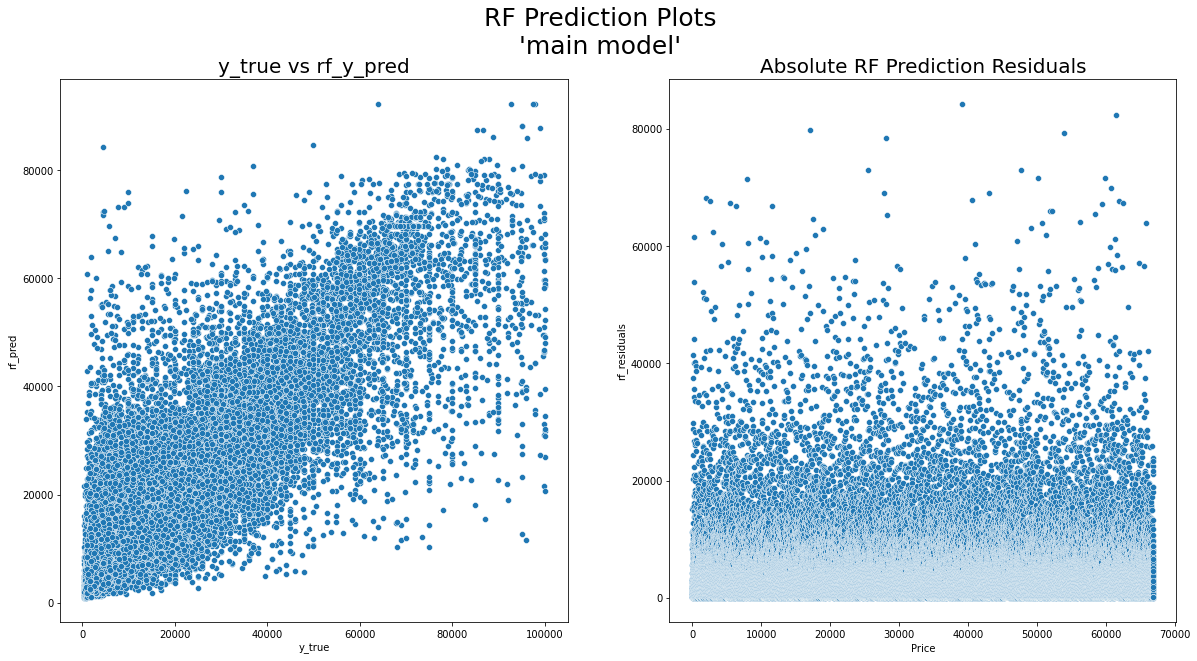

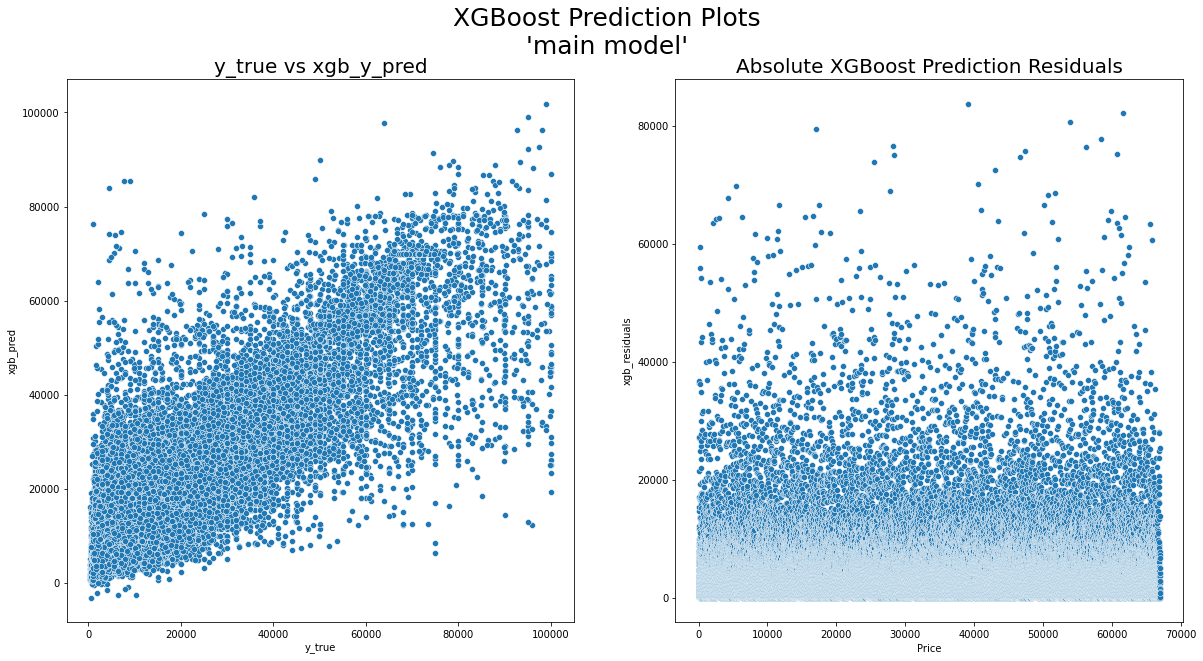

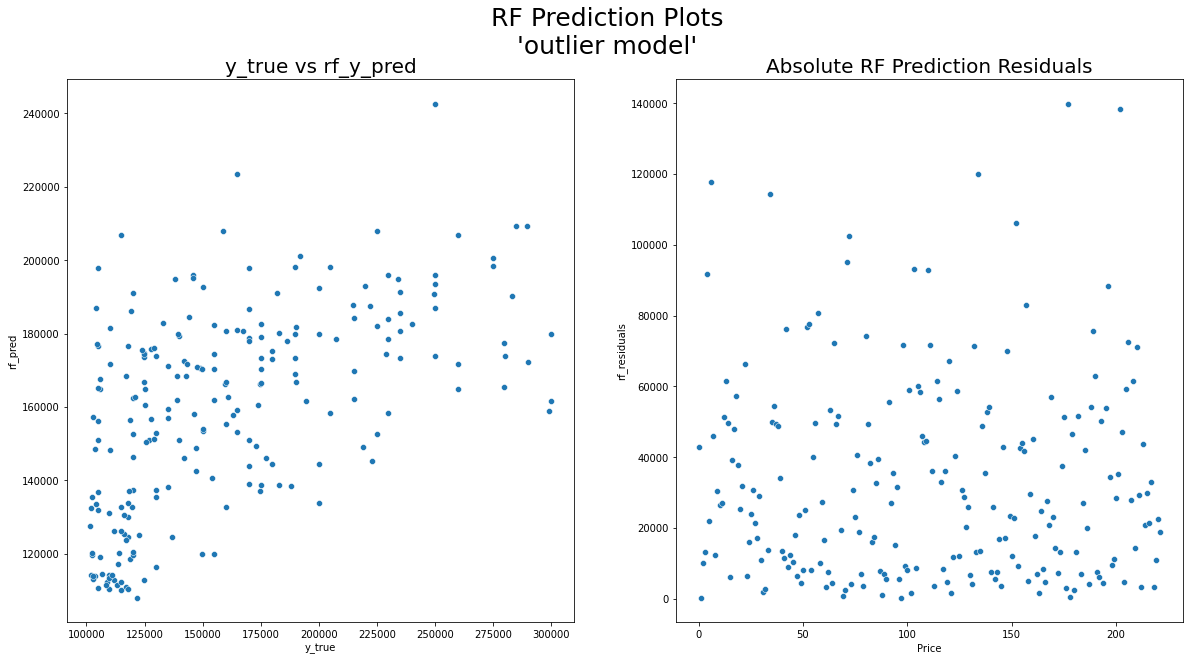

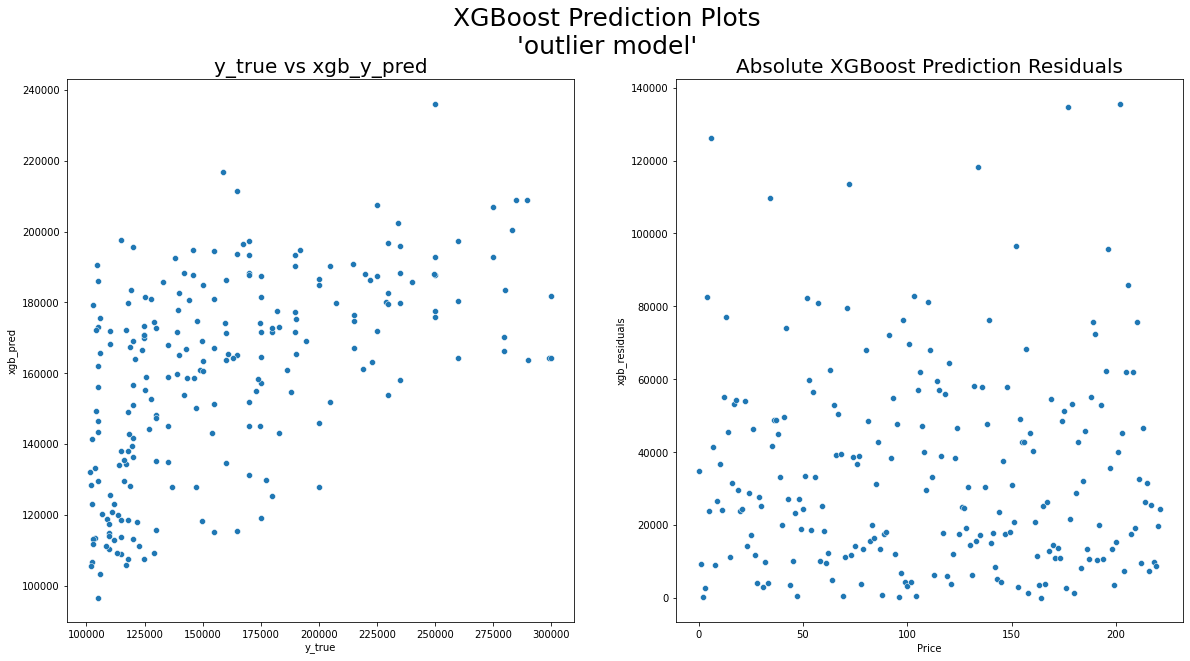

In [287]:

results_df = pd.DataFrame({'y_true': y_test, 'rf_pred': best_rf_y_pred, 'xgb_pred': xbg_preds, 'rf_residuals': y_test - best_rf_y_pred, 'xgb_residuals': y_test - xbg_preds})
outlier_results_df = pd.DataFrame({'y_true': y_test_outlier, 'rf_pred': best_rf_outlier_y_pred, 'xgb_pred': outlier_xbg_preds, 'rf_residuals': y_test_outlier - best_rf_outlier_y_pred, 'xgb_residuals': y_test_outlier - outlier_xbg_preds})

# RF plots
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
sns.scatterplot(x='y_true', y='rf_pred', data=results_df, ax=axes[0])
sns.scatterplot(data=abs(results_df['rf_residuals']), ax=axes[1])
plt.suptitle("RF Prediction Plots\n'main model'", fontsize=25)
axes[0].set_title("y_true vs rf_y_pred", fontsize=20)
axes[1].set_title("Absolute RF Prediction Residuals", fontsize=20)
axes[1].set_xlabel("Price")
plt.show()

# XGB plots
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
sns.scatterplot(x='y_true', y='xgb_pred', data=results_df, ax=axes[0])
sns.scatterplot(data=abs(results_df['xgb_residuals']), ax=axes[1])
plt.suptitle("XGBoost Prediction Plots\n'main model'", fontsize=25)
axes[0].set_title("y_true vs xgb_y_pred", fontsize=20)
axes[1].set_title("Absolute XGBoost Prediction Residuals", fontsize=20)
axes[1].set_xlabel("Price")
plt.show()

## Outlier Model
# RF plots
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
sns.scatterplot(x='y_true', y='rf_pred', data=outlier_results_df, ax=axes[0])
sns.scatterplot(data=abs(outlier_results_df['rf_residuals']), ax=axes[1])
plt.suptitle("RF Prediction Plots\n'outlier model'", fontsize=25)
axes[0].set_title("y_true vs rf_y_pred", fontsize=20)
axes[1].set_title("Absolute RF Prediction Residuals", fontsize=20)
axes[1].set_xlabel("Price")
plt.show()

# XGB plots
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
sns.scatterplot(x='y_true', y='xgb_pred', data=outlier_results_df, ax=axes[0])
sns.scatterplot(data=abs(outlier_results_df['xgb_residuals']), ax=axes[1])
plt.suptitle("XGBoost Prediction Plots\n'outlier model'", fontsize=25)
axes[0].set_title("y_true vs xgb_y_pred", fontsize=20)
axes[1].set_title("Absolute XGBoost Prediction Residuals", fontsize=20)
axes[1].set_xlabel("Price")
plt.show()

### Two Model Approach
In the second iteration of this model I applied some extra steps in the pre-processing stage. Firstly I filtered out all examples with a price <= £100,000 - this partition represented a 'typical' car. Whilst this threshold is somehwat arbritrary, it seemed like a good starting point for this dataset. If we had used a IQR technique across the whole dataset, any car over ~£45k would be excluded and a large proportion of data points would be dropped. Instead, I applied the IQR technique to the remaining 'outliers', which in my case was any car priced over £100,000. This was in order to create new outliers in the hope that we could retain as much genuine data as possible whilst extreme outliers (erroneous and genuine) are excluded. Using this technique, only 0.08% of the ingested data is dropped. The only limitation for this technique of splitting the data and training several models is that the 'hypercar model' has considerably less data (only about 2,000 examples) which means that after splitting into train, test and validation sets, the amount of data is quite small. 


#### Plotting the training of the XGBoost Models

In [294]:
# best_xgb.save_model('main_model.json')
# outlier_best_xgb.save_model('outlier_mode.json')


# fig, axes = plt.subplots(1, 2, figsize=(20, 10))
# best_xgb_feature_map = dict(zip(features_out, best_xgb.feature_importances_))
# best_xgb_feature_map = dict(sorted(best_xgb_feature_map.items(), key=lambda item: item[1], reverse=True))

# outlier_best_xgb_map = dict(zip(outlier_features_out, outlier_best_xgb.feature_importances_))
# outlier_best_xgb_map = dict(sorted(outlier_best_xgb_map.items(), key=lambda item: item[1], reverse=True))




# model_rmse = best_xgb.evals_result_['validation_0']['rmse']
# outlier_model_rmse = outlier_best_xgb.evals_result_['validation_0']['rmse']
# fig, axes = plt.subplots(1, 2, figsize=(20, 10))
# model_iters = [_ for _ in range(len(model_rmse))]
# outlier_model_iters = [_ for _ in range(len(outlier_model_rmse))]

# sns.lineplot(x=outlier_model_iters, y=outlier_model_rmse, ax=axes[1])

# xgb.plot_importance(best_xgb, ax=axes[0])
# xgb.plot_importance(outlier_best_xgb, ax=axes[1])
# axes[0].set_xlabel("Weight")
# axes[1].set_xlabel("Weight")


# model_rmse = best_xgb.evals_result_['validation_0']['rmse']
# outlier_model_rmse = outlier_best_xgb.evals_result_['validation_0']['rmse']
# fig, axes = plt.subplots(1, 2, figsize=(20, 10))
# model_iters = [_ for _ in range(len(model_rmse))]
# outlier_model_iters = [_ for _ in range(len(outlier_model_rmse))]

# sns.lineplot(x=outlier_model_iters, y=outlier_model_rmse, ax=axes[1])

# xgb.plot_importance(best_xgb, ax=axes[0])
# xgb.plot_importance(outlier_best_xgb, ax=axes[1])
# axes[0].set_xlabel("Weight")
# axes[1].set_xlabel("Weight")


# model_rmse = best_xgb.evals_result_['validation_0']['rmse']
# outlier_model_rmse = outlier_best_xgb.evals_result_['validation_0']['rmse']
# fig, axes = plt.subplots(1, 2, figsize=(20, 10))
# model_iters = [_ for _ in range(len(model_rmse))]
# outlier_model_iters = [_ for _ in range(len(outlier_model_rmse))]

# sns.lineplot(x=outlier_model_iters, y=outlier_model_rmse, ax=axes[1])

# xgb.plot_importance(best_xgb, ax=axes[0])
# xgb.plot_importance(outlier_best_xgb, ax=axes[1])
# axes[0].set_xlabel("Weight")
# axes[1].set_xlabel("Weight")


# model_rmse = best_xgb.evals_result_['validation_0']['rmse']
# outlier_model_rmse = outlier_best_xgb.evals_result_['validation_0']['rmse']
# fig, axes = plt.subplots(1, 2, figsize=(20, 10))
# model_iters = [_ for _ in range(len(model_rmse))]
# outlier_model_iters = [_ for _ in range(len(outlier_model_rmse))]

# sns.lineplot(x=outlier_model_iters, y=outlier_model_rmse, ax=axes[1])

# xgb.plot_importance(best_xgb, ax=axes[0])
# xgb.plot_importance(outlier_best_xgb, ax=axes[1])
# axes[0].set_xlabel("Weight")
# axes[1].set_xlabel("Weight")


# model_rmse = best_xgb.evals_result_['validation_0']['rmse']
# outlier_model_rmse = outlier_best_xgb.evals_result_['validation_0']['rmse']
# fig, axes = plt.subplots(1, 2, figsize=(20, 10))
# model_iters = [_ for _ in range(len(model_rmse))]
# outlier_model_iters = [_ for _ in range(len(outlier_model_rmse))]

# sns.lineplot(x=outlier_model_iters, y=outlier_model_rmse, ax=axes[1])
# plt.show()

AttributeError: 'NoneType' object has no attribute 'get_booster'

# Exploring Different XGB Implementation with Cross-Val

In [16]:
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=1337, test_size=0.1)
xgb_dtrain = xgb.DMatrix(X_train, y_train)
# xgb_dval = xgb.DMatrix(X_val, y_val)
xgb_dtest = xgb.DMatrix(X_test, y_test)
param = {
    'max_depth': 16, 
    'eta': 0.1, 
    'objective': 'reg:squarederror',
    'eval_metric': 'mae'
    }
evallist = [(xgb_dtrain, 'train')]

In [17]:
num_round = 1000
bst = xgb.cv(param, xgb_dtrain, num_round, metrics='mae', early_stopping_rounds=5)

In [18]:
bst

,train-mae-mean,train-mae-std,test-mae-mean,test-mae-std
0,16925.475912,63.494392,16937.354818,143.993683
1,15323.347005,59.199637,15371.183268,144.886182
2,13912.184570,56.058313,14018.279622,144.999213
3,12671.313477,52.929467,12844.576823,144.611386
4,11574.495443,47.230916,11823.134115,147.078306
5,10608.156576,44.584086,10936.218424,145.644828
6,9755.651693,39.352714,10173.391602,143.546164
7,9005.082031,36.323444,9518.486979,144.321584
8,8343.281901,32.993114,8952.847331,141.189245
9,7757.857910,30.422887,8467.227214,137.015820
